# LSTM for Text Summarization with the BBC Summary Dataset

## Install Dependencies

In [1]:
!pip uninstall torch torchtext -y
!pip install torch torchtext --index-url https://download.pytorch.org/whl/cu118
!pip install rouge-score bert-score nltk

Found existing installation: torch 2.4.0
Uninstalling torch-2.4.0:
  Successfully uninstalled torch-2.4.0
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 838.3/838.3 MB 2.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 70.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 89.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 20.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Import necessary Libraries

In [2]:
# Import the libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import GloVe
from spacy.tokenizer import Tokenizer
from sklearn.model_selection import train_test_split
import spacy
import pandas as pd
import numpy as np
import os
import re
import nltk
from nltk.corpus import stopwords
import random
from tqdm import tqdm
from rouge_score import rouge_scorer
from bert_score import BERTScorer
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import corpus_bleu
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import torch
from tqdm import tqdm
import nltk
from nltk.translate.bleu_score import sentence_bleu

# Download necessary NLTK data
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Instantiate the tokenizer using Spacy

In [3]:
# Tokenizer using spacy
nlp = spacy.load("en_core_web_sm")
tokenizer = Tokenizer(nlp.vocab)

## Define a custom function to create a dataframe from the text files

In [4]:
# Add data from files into dataframe for easier access
def create_dataframe(source_text_path,target_text_path):
    txt_files_source = [file for file in os.listdir(source_text_path) if file.endswith('.txt')]
    txt_files_target = [file for file in os.listdir(target_text_path) if file.endswith('.txt')]
    df = pd.DataFrame(columns=['headlines','text'])
    for source,target in zip(txt_files_source,txt_files_target):
        assert source==target
        source_file_path = os.path.join(source_text_path, source)
        target_file_path = os.path.join(target_text_path, target)
        # Read the content of the file
        with open(source_file_path,'r',encoding='latin-1') as file:
            source_text = file.read()
        with open(target_file_path,'r',encoding='latin-1') as file:
            target_text = file.read()
        df.loc[len(df.index)] = [source_text,target_text]
    return df

## Define functions to save the weights, load them and check for accuracy

In [5]:
# Check accuracy function
def check_accuracy(output,labels):
    _ , predpos = output.max(1)
    num_samples=len(labels)
    num_correct=(predpos==labels).sum()
    return (num_correct/num_samples)*100

# Save checkpoint
def save_checkpoint(state,filename='weights.pth.tar'):
    print('Saving weights-->')
    torch.save(state,filename)

# Load checkpoint
def load_checkpoint(checkpoint,model,optim):
    print('Loading weights-->')
    model.load_state_dict(checkpoint['state_dict'])
    optim.load_state_dict(checkpoint['optimizer'])

## Create dataframes for all the folders with Text Paragraphs and Summaries in our dataset

In [6]:
df1 = create_dataframe("/kaggle/input/bbc-news-summary/BBC News Summary/News Articles/business","/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/business")
df2 = create_dataframe("/kaggle/input/bbc-news-summary/BBC News Summary/News Articles/entertainment","/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/entertainment")
df3 = create_dataframe("/kaggle/input/bbc-news-summary/BBC News Summary/News Articles/politics","/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/politics")
df4 = create_dataframe("/kaggle/input/bbc-news-summary/BBC News Summary/News Articles/sport","/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/sport")
df5 = create_dataframe("/kaggle/input/bbc-news-summary/BBC News Summary/News Articles/tech","/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/tech")

## Combine all the dataframes into one dataframe

In [7]:
df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
#df = df1.copy()

In [8]:
df.head()

,headlines,text
0,US consumer confidence up\n\nConsumers' confid...,"Wal-Mart, the largest US retailer, has said it..."
1,The 'ticking budget' facing the US\n\nThe budg...,Brute force budget cuts or spending caps would...
2,Mitsubishi in Peugeot link talks\n\nTrouble-hi...,Trouble-hit Mitsubishi Motors is in talks with...
3,BMW reveals new models pipeline\n\nBMW is prep...,Typically it takes about three years from when...
4,World leaders gather to face uncertainty\n\nMo...,"More than 2,000 business and political leaders..."


In [9]:
df.shape

(2225, 2)

## Split the data into train and test set

In [10]:
# Split into train and test sets
df = df.rename(columns = {"headlines":"source_text","text":"summary_text"})
X,Y = df["source_text"],df["summary_text"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
train_df = pd.DataFrame({'source_text': X_train, 'summary_text': Y_train})
test_df = pd.DataFrame({'source_text': X_test, 'summary_text': Y_test})

## Add contraction mapping

In [11]:
import nltk
nltk.download('stopwords')
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}


stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Clean the text for punctuations and remove stop words

In [12]:
#Add text cleaner
def text_cleaner(text):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    return " ".join(tokens)

## Tokenize and lower case using lower case the tokens for training and test set

In [13]:
# Tokenize and lowercase text using spacy
train_df['source_text'] = train_df['source_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_cleaner(x))])
train_df['summary_text'] = train_df['summary_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_cleaner(x))])

test_df['source_text'] = test_df['source_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_cleaner(x))])
test_df['summary_text'] = test_df['summary_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_cleaner(x))])

## Add _START_ and _END_ tokens to the Summary

In [14]:
# Add START AND END tokens to summary
train_df['source_text'] = train_df['source_text'].apply(lambda x : ['_START_']+ x + ['_END_'])
train_df['summary_text'] = train_df['summary_text'].apply(lambda x : ['_START_']+ x + ['_END_'])

test_df['source_text'] = test_df['source_text'].apply(lambda x : ['_START_']+ x + ['_END_'])
test_df['summary_text'] = test_df['summary_text'].apply(lambda x : ['_START_']+ x + ['_END_'])

## Build vocabularies - each word has an index, note : words sorted in ascending order
 

In [15]:
all_tokens = train_df['source_text'].tolist() + train_df['summary_text'].tolist() + test_df['source_text'].tolist() + test_df['summary_text'].tolist()
source_vocab = {actual_word: idx for idx, (word_num, actual_word) in enumerate(sorted(enumerate(set(token for tokens in all_tokens for token in tokens)), key=lambda x: x[1]))}
target_vocab = {actual_word: idx for idx, (word_num, actual_word) in enumerate(sorted(enumerate(set(token for tokens in all_tokens for token in tokens)), key=lambda x: x[1]))}

In [16]:
print(all_tokens[10])

['_START_', 'watchdog', 'probes', 'e', 'mail', 'deletions', 'information', 'commissioner', 'says', 'urgently', 'asking', 'details', 'cabinet', 'office', 'orders', 'telling', 'staff', 'delete', 'e', 'mails', 'three', 'months', 'old', 'richard', 'thomas', 'totally', 'condemned', 'deletion', 'e', 'mails', 'prevent', 'disclosure', 'freedom', 'information', 'laws', 'coming', 'force', 'january', 'government', 'guidance', 'said', 'e', 'mails', 'deleted', 'served', 'current', 'purpose', 'mr', 'thomas', 'said', 'tories', 'lib', 'dems', 'questioned', 'timing', 'new', 'rules', 'tory', 'leader', 'michael', 'howard', 'written', 'tony', 'blair', 'demanding', 'explanation', 'new', 'rules', 'e', 'mail', 'retention', 'monday', 'lib', 'dem', 'constitutional', 'affairs', 'committee', 'chairman', 'alan', 'beith', 'warned', 'deletion', 'millions', 'government', 'e', 'mails', 'could', 'harm', 'ability', 'key', 'probes', 'like', 'hutton', 'inquiry', 'timing', 'new', 'rules', 'freedom', 'information', 'act', 

In [17]:
len(source_vocab)

27638

## Quality check: Check if the Source and Target vocab are the same

In [18]:
source_vocab == target_vocab

True

In [19]:
temp = list(sorted(source_vocab.items()))
for word, idx in temp[-5:]:
    print(word,idx)

zuluaga 27633
zurich 27634
zutons 27635
zvonareva 27636
zvyagintsev 27637


## Load pretrained GloVe embeddings


In [20]:
global_vectors = GloVe(name='6B', dim=300)

.vector_cache/glove.6B.zip: 862MB [02:43, 5.26MB/s]                               
100%|█████████▉| 399999/400000 [00:43<00:00, 9098.49it/s]


## Assign the GloVe vectors to all our source tokens and generate source vectors

In [21]:
source_vectors = torch.stack([global_vectors.get_vecs_by_tokens(word) for word, idx in sorted(source_vocab.items(), key=lambda x: x[1])])
print(type(source_vectors), source_vectors.shape)

<class 'torch.Tensor'> torch.Size([27638, 300])


## Visualize the Embeddings

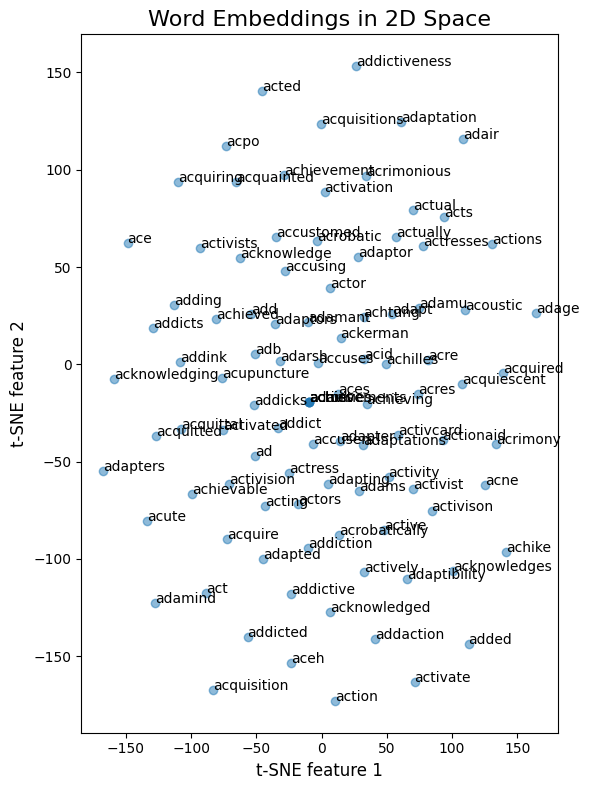

In [22]:
def plot_embeddings(embeddings, words, n=100, title="Word Embeddings Visualization"):
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(embeddings[:n,:])
    
    plt.figure(figsize=(6, 8))
    plt.scatter(Y[:, 0], Y[:, 1], alpha=0.5)
    
    for label, x, y in zip(words[:n], Y[:, 0], Y[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
    
    plt.title(title, fontsize=16)
    plt.xlabel("t-SNE feature 1", fontsize=12)
    plt.ylabel("t-SNE feature 2", fontsize=12)
    plt.tight_layout()
    plt.show()

# Usage
words = list(source_vocab.keys())[200:300]  # Take first 10 words
plot_embeddings(source_vectors, words, title="Word Embeddings in 2D Space")

## Switch to Kaggle GPU for faster training

In [23]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
device

device(type='cuda')

## Converting words to their corresponding vocabulary indices.

In [25]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, source_texts, target_summaries, source_vocab, target_vocab):
        self.source_texts = source_texts
        self.target_summaries = target_summaries
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab

    def __len__(self):
        return len(self.source_texts)

    def __getitem__(self, idx):
        source_text = [self.source_vocab[word] for word in self.source_texts[idx]]
        target_summary = [self.target_vocab[word] for word in self.target_summaries[idx]]
        return torch.tensor(source_text), torch.tensor(target_summary)

# Create custom datasets

In [26]:
train_dataset = CustomDataset(train_df['source_text'].tolist(), train_df['summary_text'].tolist(), source_vocab, target_vocab)
test_dataset = CustomDataset(test_df['source_text'].tolist(), test_df['summary_text'].tolist(), source_vocab, target_vocab)

## Vocabulary Coverage Analysis Visualization

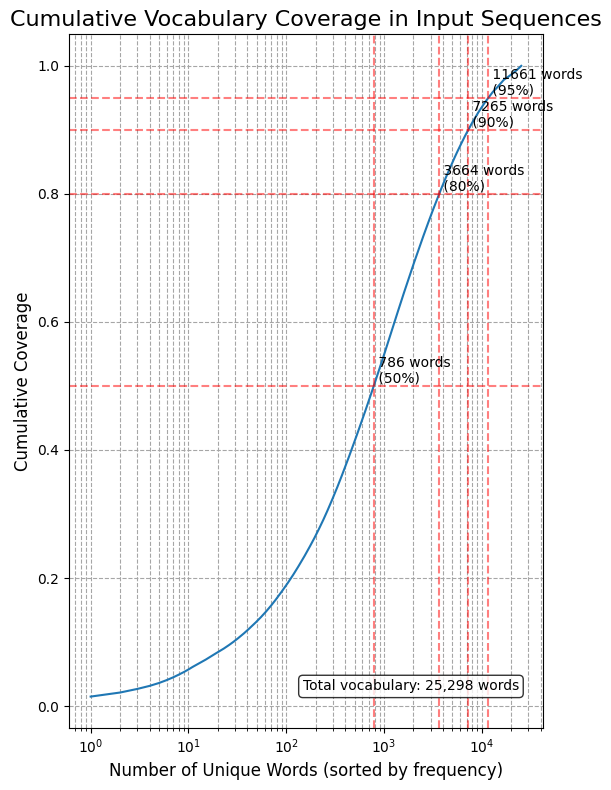

In [27]:
def plot_vocab_coverage(texts, title="Cumulative Vocabulary Coverage"):
    all_words = [word for text in texts for word in text]
    word_counts = Counter(all_words)
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    
    cumulative_coverage = np.cumsum([count for word, count in sorted_words]) / len(all_words)
    
    plt.figure(figsize=(6, 8))
    plt.plot(range(1, len(cumulative_coverage) + 1), cumulative_coverage)
    
    plt.title(title, fontsize=16)
    plt.xlabel('Number of Unique Words (sorted by frequency)', fontsize=12)
    plt.ylabel('Cumulative Coverage', fontsize=12)
    plt.xscale('log')
    plt.grid(True, which="both", ls="--", c='0.65')
    
    # Add reference lines
    coverage_levels = [0.5, 0.8, 0.9, 0.95]
    for level in coverage_levels:
        words_needed = np.argmax(cumulative_coverage >= level) + 1
        plt.axhline(y=level, color='r', linestyle='--', alpha=0.5)
        plt.axvline(x=words_needed, color='r', linestyle='--', alpha=0.5)
        plt.text(words_needed, level, f' {words_needed} words\n ({level:.0%})', 
                 verticalalignment='bottom', horizontalalignment='left')
    
    # Add annotation for total vocabulary size
    total_vocab = len(word_counts)
    plt.text(0.95, 0.05, f'Total vocabulary: {total_vocab:,} words', 
             transform=plt.gca().transAxes, ha='right', va='bottom', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Usage
plot_vocab_coverage(train_df['source_text'], title="Cumulative Vocabulary Coverage in Input Sequences")

## Distribution of Sequence Lengths

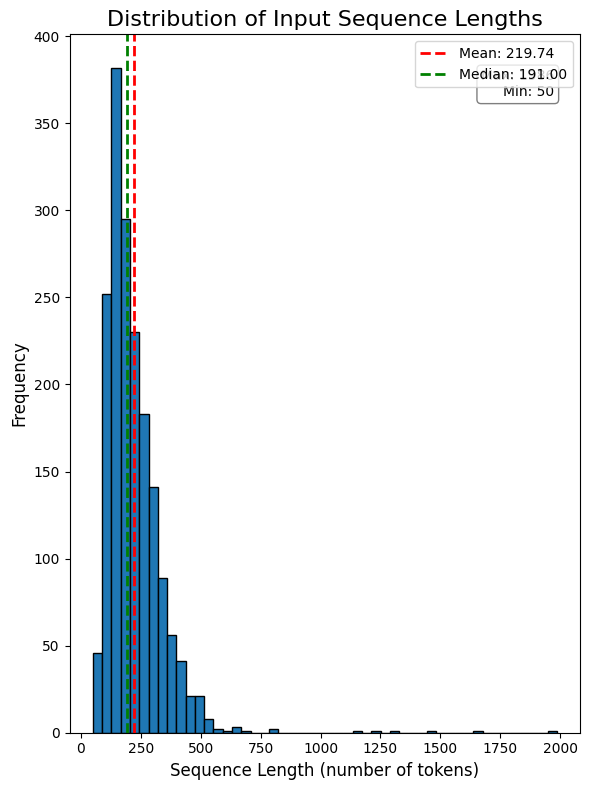

In [28]:
def plot_sequence_lengths(data, title="Distribution of Sequence Lengths"):
    # Check if the elements are lists or strings
    if isinstance(data[0], list):
        lengths = [len(seq) for seq in data]
    else:
        lengths = [len(seq.split()) for seq in data]  # For string sequences
    
    plt.figure(figsize=(6, 8))
    n, bins, patches = plt.hist(lengths, bins=50, edgecolor='black')
    
    # Add mean and median lines
    mean_length = np.mean(lengths)
    median_length = np.median(lengths)
    plt.axvline(mean_length, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_length:.2f}')
    plt.axvline(median_length, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_length:.2f}')
    
    plt.title(title, fontsize=16)
    plt.xlabel('Sequence Length (number of tokens)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    
    # Add text with statistics
    max_length = max(lengths)
    min_length = min(lengths)
    plt.text(0.95, 0.95, f'Max: {max_length}\nMin: {min_length}', 
             transform=plt.gca().transAxes, va='top', ha='right', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

# Usage
plot_sequence_lengths(train_df['source_text'], title="Distribution of Input Sequence Lengths")

## Define collate function for DataLoader

In [29]:
def collate_fn(batch):
    sources, targets = zip(*batch)
    padded_sources = pad_sequence(sources, batch_first=True)
    padded_targets = pad_sequence(targets, batch_first=True)
    return padded_sources, padded_targets

## Define the Encoder Architecture using LSTM

In [30]:
class Encoder(nn.Module):
    def __init__(self, source_vectors, embedding_dim, hidden_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(source_vectors, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=False, dropout=dropout, batch_first=True)

    def forward(self, X):
        # X shape = [Batch_Size X Sequence_Len X 1]
        X = self.embedding(X)
        # X shape = [Batch_Size X Sequence_Len X Embedding_Dim]
        assert X.shape[0]>0 and X.shape[1]>0
        X,(hidden_state,cell_state) = self.lstm(X)
        # X shape = [Batch_Size X Seq_Len X Hidden_Dim] , Hidden_State_Shape = Cell_State_Shape = [Num_Layers X Batch_Size X Hidden_Dim]
        return hidden_state,cell_state

## Define the Decoder Architecture using LSTM

In [31]:
class Decoder(nn.Module):
    def __init__(self, source_vectors, target_vocab_size, embedding_dim, hidden_dim, n_layers, dropout):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.target_vocab_size = target_vocab_size
        # Initialize embedding layer with pre-trained vectors
        self.embedding = nn.Embedding.from_pretrained(source_vectors, freeze=False)
        # LSTM layer for sequence processing
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=False, dropout=dropout, batch_first=True)
        # Final fully connected layer to project to vocabulary size
        self.fc = nn.Linear(hidden_dim, target_vocab_size)

    def forward(self, hidden_state, cell_state, Y, force_correction=0.5):
        batch_size, seq_len = Y.shape[0], Y.shape[1]
        # Initialize output tensor
        outputs = torch.zeros(seq_len, batch_size, self.target_vocab_size).to(Y.device)
        
        # Start with the first token of the sequence
        X = Y[:, 0]  # Changed from Y[:, 1] to Y[:, 0]
        
        for i in range(seq_len):
            X = X.unsqueeze(1)  # Add sequence dimension
            decoder_input = self.embedding(X)  # Convert token to embedding
            
            # Process through LSTM
            decoder_output, (hidden_state, cell_state) = self.lstm(decoder_input, (hidden_state, cell_state))
            decoder_output = self.fc(decoder_output)  # Project to vocabulary size
            
            outputs[i] = decoder_output.squeeze(1)  # Store output for current step
            
            # Get the most likely token
            _, indexes = decoder_output.max(dim=2)
            indexes = indexes.squeeze(1)
            
            # Teacher forcing: use predicted token or true token based on force_correction probability
            X = indexes if random.random() > force_correction else Y[:, i]
        
        # Rearrange output dimensions to (batch_size, seq_len, vocab_size)
        outputs = outputs.permute(1, 0, 2)
        return outputs

## Implement the Encoder-Decoder LSTM

In [32]:
class EncDecLSTM(nn.Module):
    def __init__(self,enc,dec):
        super(EncDecLSTM,self).__init__()
        self.enc = enc
        self.dec = dec
        
    def forward(self,X,Y):
        hidden_state,cell_state = self.enc(X)
        output = self.dec(hidden_state,cell_state,Y)
        return output

## Initialize the parameters and call the model

In [33]:
# Instantiate the parameters
input_dim = len(source_vocab)
output_dim = len(target_vocab)
learning_rate = 0.001
embedding_dim = 300  
hidden_dim = 512
n_layers = 2 #Going at layers =3 did not significantly change the Scores so stuck to 2 layers
dropout = 0.2
num_epochs = 40
num_workers = 3

# Call the encoder
encoder = Encoder(source_vectors, embedding_dim, hidden_dim, n_layers, dropout)
# Call the decoder
decoder = Decoder(source_vectors, output_dim, embedding_dim, hidden_dim, n_layers, dropout)
#Call the model
model = EncDecLSTM(encoder,decoder)
print(model)

EncDecLSTM(
  (enc): Encoder(
    (embedding): Embedding(27638, 300)
    (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.2)
  )
  (dec): Decoder(
    (embedding): Embedding(27638, 300)
    (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.2)
    (fc): Linear(in_features=512, out_features=27638, bias=True)
  )
)


In [34]:
# Check the encoder parameters
trainable_params = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
print(trainable_params)

12059720


In [35]:
#Check the model parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

38297734


## Specify optimizer and loss function

In [36]:
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fun = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

## Create dataloaders

In [37]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn, num_workers=num_workers)

## Data Batch Extraction Example

In [38]:
source_dummy,target_dummy = next(iter(train_loader))

In [39]:
#Check the shape
print(source_dummy.shape,target_dummy.shape)

torch.Size([8, 341]) torch.Size([8, 157])


In [40]:
# Call the prediction and check its prediction
y_pred = model(source_dummy,target_dummy)
print(y_pred.shape,target_dummy.shape)

torch.Size([8, 157, 27638]) torch.Size([8, 157])


## Define a function to evaluate the model

In [41]:
def evaluate_model(model, test_loader, target_vocab):
    model.eval()  # Set the model to evaluation mode
    hypotheses = []
    references = []
    
    # Create a reverse vocabulary for converting indices back to words
    reverse_target_vocab = {v: k for k, v in target_vocab.items()}
    
    # Initialize the ROUGE scorer with specific ROUGE variants
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    with torch.no_grad():  # Disable gradient calculation for inference
        for source, target in test_loader:
            source = source.to(device)
            target = target.to(device)
            
            # Generate summary for the first sample in the batch
            decoded_sequence = decode_sequence(model, source[0], target_vocab)
            hypotheses.append(' '.join(decoded_sequence))
            
            # Convert target tensor to words
            target_words = []
            for t in target[0]:
                idx = t.item()
                if idx in reverse_target_vocab:
                    target_words.append(reverse_target_vocab[idx])
            references.append(' '.join(target_words))
    
    # Initialize ROUGE scores dictionary
    rouge_scores = {key: {'f': 0, 'p': 0, 'r': 0} for key in ['rouge1', 'rouge2', 'rougeL']}
    
    # Calculate ROUGE scores for each hypothesis-reference pair
    for hyp, ref in zip(hypotheses, references):
        scores = scorer.score(ref, hyp)
        for key in scores:
            rouge_scores[key]['f'] += scores[key].fmeasure
            rouge_scores[key]['p'] += scores[key].precision
            rouge_scores[key]['r'] += scores[key].recall
    
    # Average ROUGE scores across all samples
    n = len(hypotheses)
    for key in rouge_scores:
        for metric in rouge_scores[key]:
            rouge_scores[key][metric] /= n
    
    # Calculate BLEU score
    bleu_score = corpus_bleu([[r.split()] for r in references], [h.split() for h in hypotheses])
    
    return rouge_scores, bleu_score

## Define the training loop

In [42]:
def train_loop(model, dataloader, loss_fun, optimizer, device, scheduler=None, num_epochs=40):
    model.train()  # Set model to training mode
    model.to(device)  # Move model to specified device (CPU/GPU)
    min_loss = float('inf')
    
    # Lists to store metrics for each epoch
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(num_epochs):
        losses = []
        accuracies = []
        loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)  # Progress bar
        for batch, (x, y) in loop:
            x = x.to(device)  # Move input to device
            y = y.to(device)  # Move target to device
            y_pred = model(x, y)  # Forward pass

            # Reshape predictions and targets for loss calculation
            batch_size, seq_len, vocab_size = y_pred.shape
            y_pred = y_pred.reshape(-1, vocab_size)
            y = y.reshape(-1)

            # Calculate loss & accuracy
            loss = loss_fun(y_pred, y)
            losses.append(loss.item())
            accuracy = check_accuracy(y_pred, y)
            accuracies.append(accuracy)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()

            if scheduler:
                scheduler.step()  # Update learning rate

            # Update progress bar
            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=loss.item(), accuracy=accuracy)

        # Calculate average loss and accuracy for the epoch
        moving_loss = sum(losses) / len(losses)
        moving_accuracy = sum(accuracies) / len(accuracies)
        
        # Store epoch metrics (move to CPU if they are tensors)
        epoch_losses.append(moving_loss.cpu().item() if isinstance(moving_loss, torch.Tensor) else moving_loss)
        epoch_accuracies.append(moving_accuracy.cpu().item() if isinstance(moving_accuracy, torch.Tensor) else moving_accuracy)

        # Save checkpoint if loss improved
        checkpoint = {
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        if moving_loss < min_loss:
            min_loss = moving_loss
            save_checkpoint(checkpoint)

        print(f'Epoch {epoch+1}: Loss = {moving_loss:.4f}, Training Accuracy = {moving_accuracy:.4f}')

    return model, epoch_losses, epoch_accuracies

## Train the model

In [43]:
model, epoch_losses, epoch_accuracies = train_loop(model, train_loader, loss_fun, optimizer, device, scheduler, num_epochs=num_epochs)

Epoch [1/40]: 100%|██████████| 223/223 [02:39<00:00,  1.39it/s, accuracy=tensor(48.0556, device='cuda:0'), loss=4.51]


Saving weights-->
Epoch 1: Loss = 5.4516, Training Accuracy = 43.3263


Epoch [2/40]: 100%|██████████| 223/223 [02:39<00:00,  1.40it/s, accuracy=tensor(28.1073, device='cuda:0'), loss=6.15]


Saving weights-->
Epoch 2: Loss = 4.8532, Training Accuracy = 44.0632


Epoch [3/40]: 100%|██████████| 223/223 [02:38<00:00,  1.41it/s, accuracy=tensor(31.5022, device='cuda:0'), loss=5.85]


Saving weights-->
Epoch 3: Loss = 4.7790, Training Accuracy = 44.3030


Epoch [4/40]: 100%|██████████| 223/223 [02:37<00:00,  1.42it/s, accuracy=tensor(44.5531, device='cuda:0'), loss=4.78]

Epoch 4: Loss = 4.7930, Training Accuracy = 43.8426



Epoch [5/40]: 100%|██████████| 223/223 [02:40<00:00,  1.39it/s, accuracy=tensor(18.0921, device='cuda:0'), loss=7.02]


Saving weights-->
Epoch 5: Loss = 4.6928, Training Accuracy = 44.6434


Epoch [6/40]: 100%|██████████| 223/223 [02:37<00:00,  1.42it/s, accuracy=tensor(25.4967, device='cuda:0'), loss=6.2] 


Saving weights-->
Epoch 6: Loss = 4.6523, Training Accuracy = 44.2465


Epoch [7/40]: 100%|██████████| 223/223 [02:37<00:00,  1.41it/s, accuracy=tensor(26.9928, device='cuda:0'), loss=5.88]


Saving weights-->
Epoch 7: Loss = 4.5569, Training Accuracy = 44.2339


Epoch [8/40]: 100%|██████████| 223/223 [02:38<00:00,  1.41it/s, accuracy=tensor(38.1048, device='cuda:0'), loss=4.82]


Saving weights-->
Epoch 8: Loss = 4.4579, Training Accuracy = 44.4524


Epoch [9/40]: 100%|██████████| 223/223 [02:39<00:00,  1.40it/s, accuracy=tensor(34.5912, device='cuda:0'), loss=5.48]


Saving weights-->
Epoch 9: Loss = 4.4006, Training Accuracy = 44.4817


Epoch [10/40]: 100%|██████████| 223/223 [02:38<00:00,  1.41it/s, accuracy=tensor(40.2778, device='cuda:0'), loss=4.44]


Saving weights-->
Epoch 10: Loss = 4.3545, Training Accuracy = 44.2097


Epoch [11/40]: 100%|██████████| 223/223 [02:36<00:00,  1.43it/s, accuracy=tensor(49.7917, device='cuda:0'), loss=3.72]


Saving weights-->
Epoch 11: Loss = 4.3313, Training Accuracy = 43.7517


Epoch [12/40]: 100%|██████████| 223/223 [02:39<00:00,  1.40it/s, accuracy=tensor(41.7763, device='cuda:0'), loss=4.63]


Saving weights-->
Epoch 12: Loss = 4.1998, Training Accuracy = 44.8603


Epoch [13/40]: 100%|██████████| 223/223 [02:36<00:00,  1.43it/s, accuracy=tensor(34.9138, device='cuda:0'), loss=5.13]

Epoch 13: Loss = 4.2068, Training Accuracy = 44.0296



Epoch [14/40]: 100%|██████████| 223/223 [02:39<00:00,  1.40it/s, accuracy=tensor(26.2640, device='cuda:0'), loss=5.81]


Saving weights-->
Epoch 14: Loss = 4.0890, Training Accuracy = 44.8875


Epoch [15/40]: 100%|██████████| 223/223 [02:36<00:00,  1.42it/s, accuracy=tensor(20.7071, device='cuda:0'), loss=6.11]

Epoch 15: Loss = 4.1219, Training Accuracy = 44.0113



Epoch [16/40]: 100%|██████████| 223/223 [02:37<00:00,  1.42it/s, accuracy=tensor(31.8182, device='cuda:0'), loss=5]   


Saving weights-->
Epoch 16: Loss = 4.0193, Training Accuracy = 44.5644


Epoch [17/40]: 100%|██████████| 223/223 [02:39<00:00,  1.40it/s, accuracy=tensor(30.5147, device='cuda:0'), loss=5.03]


Saving weights-->
Epoch 17: Loss = 3.9319, Training Accuracy = 45.4007


Epoch [18/40]: 100%|██████████| 223/223 [02:35<00:00,  1.43it/s, accuracy=tensor(43.1338, device='cuda:0'), loss=4.13]


Saving weights-->
Epoch 18: Loss = 3.9096, Training Accuracy = 45.0514


Epoch [19/40]: 100%|██████████| 223/223 [02:40<00:00,  1.39it/s, accuracy=tensor(32.8231, device='cuda:0'), loss=4.83]


Saving weights-->
Epoch 19: Loss = 3.8076, Training Accuracy = 46.0174


Epoch [20/40]: 100%|██████████| 223/223 [02:40<00:00,  1.39it/s, accuracy=tensor(28.8265, device='cuda:0'), loss=5.05]


Saving weights-->
Epoch 20: Loss = 3.7419, Training Accuracy = 46.2854


Epoch [21/40]: 100%|██████████| 223/223 [02:38<00:00,  1.41it/s, accuracy=tensor(30.2632, device='cuda:0'), loss=5]   


Saving weights-->
Epoch 21: Loss = 3.7388, Training Accuracy = 45.9184


Epoch [22/40]: 100%|██████████| 223/223 [02:38<00:00,  1.41it/s, accuracy=tensor(22.2222, device='cuda:0'), loss=5.07]


Saving weights-->
Epoch 22: Loss = 3.6943, Training Accuracy = 46.0192


Epoch [23/40]: 100%|██████████| 223/223 [02:39<00:00,  1.40it/s, accuracy=tensor(33.9372, device='cuda:0'), loss=4.57]


Saving weights-->
Epoch 23: Loss = 3.6785, Training Accuracy = 45.9001


Epoch [24/40]: 100%|██████████| 223/223 [02:40<00:00,  1.39it/s, accuracy=tensor(49.7041, device='cuda:0'), loss=3.36]


Saving weights-->
Epoch 24: Loss = 3.5799, Training Accuracy = 46.7139


Epoch [25/40]: 100%|██████████| 223/223 [02:38<00:00,  1.41it/s, accuracy=tensor(28.3854, device='cuda:0'), loss=5.12]

Epoch 25: Loss = 3.5972, Training Accuracy = 46.2805



Epoch [26/40]: 100%|██████████| 223/223 [02:37<00:00,  1.41it/s, accuracy=tensor(17.6768, device='cuda:0'), loss=5.65]


Saving weights-->
Epoch 26: Loss = 3.5603, Training Accuracy = 46.3152


Epoch [27/40]: 100%|██████████| 223/223 [02:37<00:00,  1.42it/s, accuracy=tensor(42.2932, device='cuda:0'), loss=3.97]


Saving weights-->
Epoch 27: Loss = 3.4961, Training Accuracy = 46.8796


Epoch [28/40]: 100%|██████████| 223/223 [02:36<00:00,  1.42it/s, accuracy=tensor(40.1840, device='cuda:0'), loss=3.86]


Saving weights-->
Epoch 28: Loss = 3.4896, Training Accuracy = 46.5961


Epoch [29/40]: 100%|██████████| 223/223 [02:39<00:00,  1.40it/s, accuracy=tensor(42.0635, device='cuda:0'), loss=3.59]


Saving weights-->
Epoch 29: Loss = 3.3831, Training Accuracy = 47.8165


Epoch [30/40]: 100%|██████████| 223/223 [02:39<00:00,  1.40it/s, accuracy=tensor(36., device='cuda:0'), loss=3.96]    

Epoch 30: Loss = 3.3835, Training Accuracy = 47.8538



Epoch [31/40]: 100%|██████████| 223/223 [02:35<00:00,  1.43it/s, accuracy=tensor(64.2553, device='cuda:0'), loss=2.17]


Saving weights-->
Epoch 31: Loss = 3.3729, Training Accuracy = 47.6414


Epoch [32/40]: 100%|██████████| 223/223 [02:37<00:00,  1.41it/s, accuracy=tensor(45.5307, device='cuda:0'), loss=3.53]


Saving weights-->
Epoch 32: Loss = 3.3334, Training Accuracy = 47.9152


Epoch [33/40]: 100%|██████████| 223/223 [02:38<00:00,  1.41it/s, accuracy=tensor(39.7388, device='cuda:0'), loss=3.66]


Saving weights-->
Epoch 33: Loss = 3.2891, Training Accuracy = 48.3482


Epoch [34/40]: 100%|██████████| 223/223 [02:38<00:00,  1.40it/s, accuracy=tensor(33.1117, device='cuda:0'), loss=4.47]


Saving weights-->
Epoch 34: Loss = 3.2400, Training Accuracy = 48.6604


Epoch [35/40]: 100%|██████████| 223/223 [02:38<00:00,  1.41it/s, accuracy=tensor(29.4492, device='cuda:0'), loss=4.28]


Saving weights-->
Epoch 35: Loss = 3.2101, Training Accuracy = 48.8787


Epoch [36/40]: 100%|██████████| 223/223 [02:38<00:00,  1.40it/s, accuracy=tensor(31.7460, device='cuda:0'), loss=4.45]


Saving weights-->
Epoch 36: Loss = 3.1558, Training Accuracy = 49.5326


Epoch [37/40]: 100%|██████████| 223/223 [02:39<00:00,  1.40it/s, accuracy=tensor(26.9380, device='cuda:0'), loss=4.61]


Saving weights-->
Epoch 37: Loss = 3.0960, Training Accuracy = 50.0613


Epoch [38/40]: 100%|██████████| 223/223 [02:38<00:00,  1.41it/s, accuracy=tensor(38.6986, device='cuda:0'), loss=4.25]


Saving weights-->
Epoch 38: Loss = 3.0924, Training Accuracy = 49.9740


Epoch [39/40]: 100%|██████████| 223/223 [02:40<00:00,  1.39it/s, accuracy=tensor(35.5556, device='cuda:0'), loss=3.96]


Saving weights-->
Epoch 39: Loss = 3.0137, Training Accuracy = 50.9174


Epoch [40/40]: 100%|██████████| 223/223 [02:37<00:00,  1.41it/s, accuracy=tensor(55.6452, device='cuda:0'), loss=2.81]

Epoch 40: Loss = 3.0330, Training Accuracy = 50.4699


## Plot the Training loss and the Accuracy against the Epochs

<Figure size 1000x600 with 0 Axes>

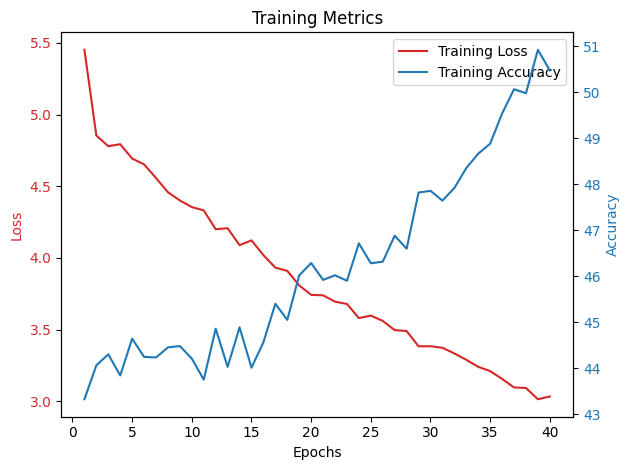

In [44]:
def plot_training_metrics(losses, accuracies):
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(10, 6))
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs, losses, color=color, label='Training Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(epochs, accuracies, color=color, label='Training Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Training Metrics')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

    plt.show()

plot_training_metrics(epoch_losses, epoch_accuracies)

## Create a function to decode the batch input into string

In [45]:
def decode_batch(x, token_ids, tokenizer):
    if isinstance(token_ids, torch.Tensor):
        token_ids = token_ids.cpu().numpy()
    if isinstance(x, torch.Tensor):
        x = x.cpu().numpy()
    
    decoded = []
    for input_seq, pred_seq in zip(x, token_ids):
        # Convert input sequence to string
        input_text = ' '.join(map(str, input_seq))
        # Tokenize the input sequence
        tokens = [token.text for token in tokenizer(input_text)]
        # Map predicted indices to tokens
        pred_tokens = [tokens[i] if i < len(tokens) else '' for i in pred_seq]
        # Join tokens into a string
        decoded.append(' '.join(pred_tokens))
    
    return decoded

## Define a function to test the data

In [46]:
def test_loop(model, dataloader, loss_fun, device, tokenizer):
    model.eval()
    model.to(device)
    losses = []
    
    # Initialize ROUGE scorer
    rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    # Lists to store ROUGE and BLEU scores
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    bleu_scores = []
    
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
    
    with torch.no_grad():
        for batch, (x, y) in loop:
            # Put on device
            x = x.to(device)
            y = y.to(device)

            # Forward pass
            y_pred = model(x, y)
            
            # Reshape tensors
            batch_size, seq_len, vocab_size = y_pred.shape
            y_pred = y_pred.contiguous().view(-1, vocab_size)
            y = y.contiguous().view(-1)
            
            # Calculate test loss
            loss = loss_fun(y_pred, y)
            losses.append(loss.item())

            # Get predicted token indices
            pred_indices = torch.argmax(y_pred, dim=-1).view(batch_size, seq_len)
            
            # Decode predictions and references
            pred_summaries = decode_batch(x, pred_indices, tokenizer)
            ref_summaries = decode_batch(x, y.view(batch_size, seq_len), tokenizer)
            
            # Calculate ROUGE and BLEU scores
            for pred, ref in zip(pred_summaries, ref_summaries):
                # ROUGE scores
                scores = rouge_scorer_obj.score(ref, pred)
                for key in rouge_scores:
                    rouge_scores[key].append(scores[key].fmeasure)
                
                # BLEU score
                bleu_scores.append(sentence_bleu([ref.split()], pred.split()))
            
            # Update TQDM progress bar
            loop.set_postfix(loss=loss.item())

    # Calculate final metrics
    avg_loss = sum(losses) / len(losses)
    final_rouge_scores = {key: sum(scores) / len(scores) for key, scores in rouge_scores.items()}
    final_bleu_score = sum(bleu_scores) / len(bleu_scores)

    print(f"Average Test Loss: {avg_loss:.4f}")
    print(f"ROUGE Scores:")
    for key, value in final_rouge_scores.items():
        print(f"  {key}: {value:.4f}")
    print(f"Average BLEU Score: {final_bleu_score:.4f}")

    return avg_loss, final_rouge_scores, final_bleu_score

## Calcualate the ROUGE and BLEU scores for Text Summarization task

In [47]:
avg_loss, rouge_scores, bleu_score = test_loop(model, test_loader, loss_fun, device, tokenizer)

  0%|          | 0/56 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  2%|▏         | 1/56 [00:00<00:15,  3.53it/s, loss=4.46]/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
 41%|████      | 23/56 [00:07<00:07,  4.38it/s, loss=4.57]/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 56/56 [00:14<00:00,  3.87it/s, loss=5.52]

Average Test Loss: 4.7896
ROUGE Scores:
  rouge1: 0.8324
  rouge2: 0.8021
  rougeL: 0.8323
Average BLEU Score: 0.8185
